# SAM and SAM 2

Using the same code to segment an image with both SAM and SAM 2.

Change the value of the constant `SAMVersion` to 1 to use SAM and 2 to use SAM 2.

The code is based on the following notebooks:

- SAM: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
- SAM 2: https://github.com/facebookresearch/segment-anything-2/blob/main/notebooks/image_predictor_example.ipynb

When in doubt, SAM 2 code was used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from segment_anything import sam_model_registry, SamPredictor
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import torch

/home/andy/segment-anything-2/sam2/modeling/sam/transformer.py:22: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:
SAMVersion = 1

In [2]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [3]:
image = Image.open('sam_1_and_2/truck.jpg')
image = np.array(image.convert('RGB'))

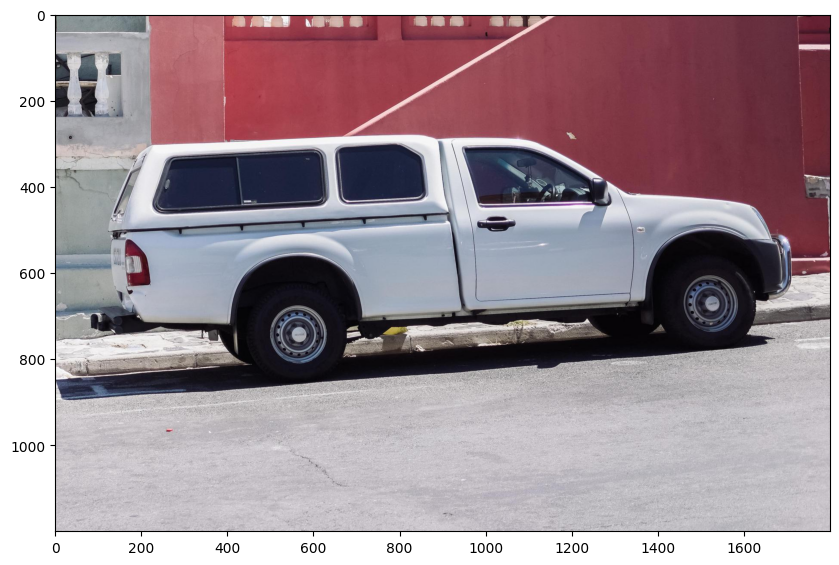

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [5]:
# SAM
if SAMVersion == 1:
    sam_checkpoint = '../model_checkpoints/sam_vit_h_4b8939.pth'
    model_type = 'vit_h'

    device = 'cuda'

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
elif SAMVersion == 2:
    torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

    if torch.cuda.get_device_properties(0).major >= 8:
        # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    sam2_checkpoint = '../model_checkpoints/sam2_hiera_large.pt'
    model_cfg = 'sam2_hiera_l.yaml'

    sam2_model = build_sam2(model_cfg, sam2_checkpoint, device='cuda')

    predictor = SAM2ImagePredictor(sam2_model)
else:
    raise NotImplementedError('Invalid SAM version')

In [6]:
predictor.set_image(image)

In [7]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

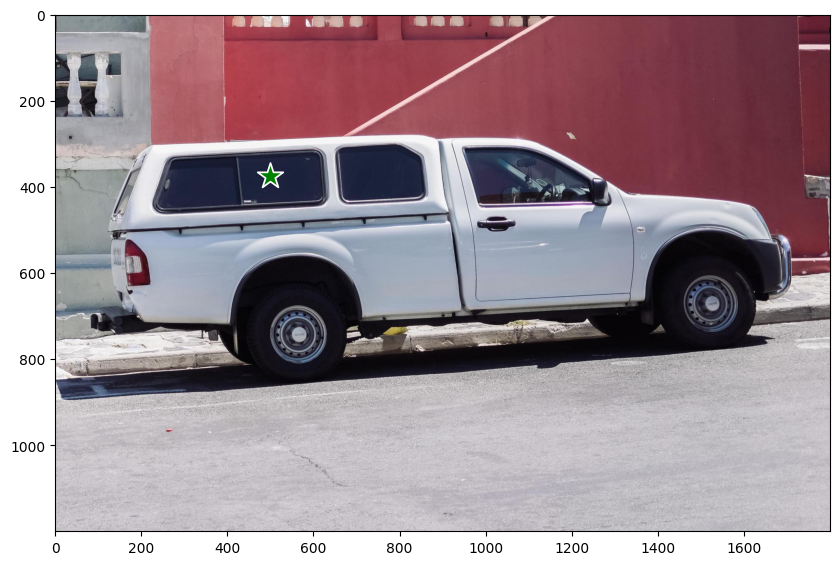

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [9]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [10]:
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

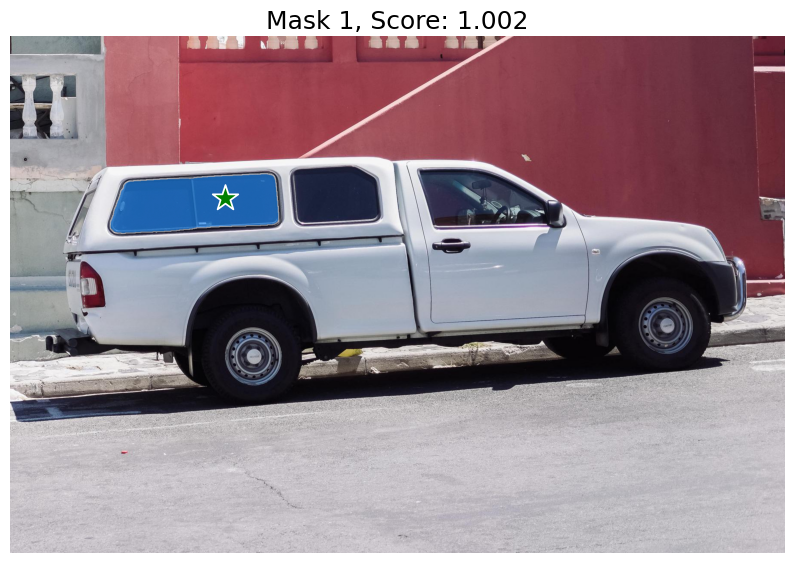

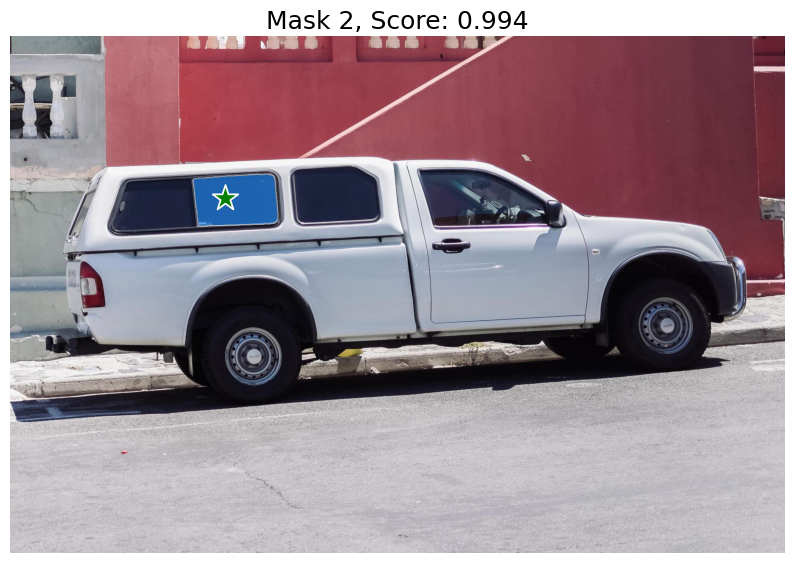

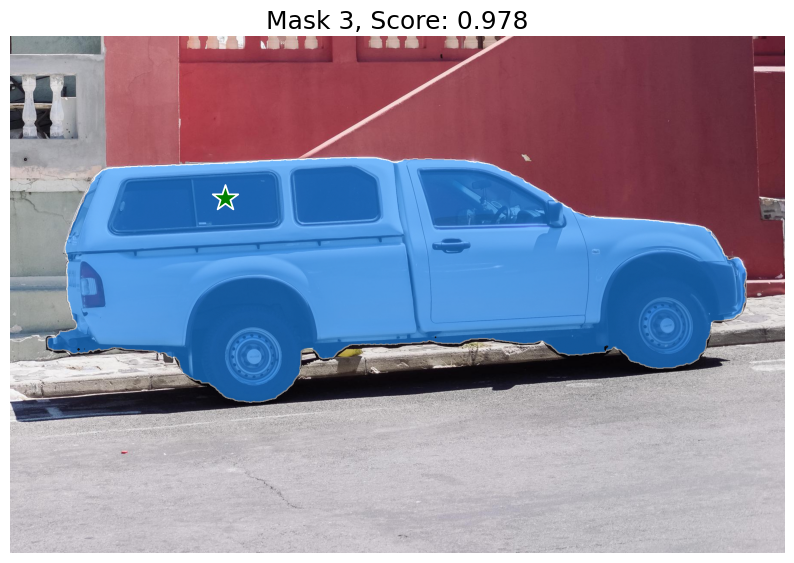

In [11]:
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)